## Imoprting required libraries:

In [37]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings("ignore")

## Reading data:

In [38]:
data = pd.read_csv('Hourly-2019.csv')
data.head()

,Date Time,T (degC),Spec_H (g/kg),Rel_H (5),Prep (mm/hr),Pressure (kPa),WV (10M),WD (10M),WV (50M),WD (50M),AllSky_Irr (Wh/m^2),Clrsky_Irr (Wh/m^2),Zenith
0,01.01.2019 00:00,27.40,19.29,84.38,1.09,100.57,0.90,84.54,1.06,88.30,0.00,0.00,NaN
1,01.01.2019 01:00,27.20,19.23,85.19,1.51,100.51,1.09,107.53,1.30,111.16,0.00,0.00,NaN
2,01.01.2019 02:00,26.96,19.23,86.25,1.88,100.47,1.40,119.15,1.71,122.09,0.00,0.00,NaN
3,01.01.2019 03:00,26.76,19.23,87.38,1.97,100.46,1.80,116.34,2.22,118.55,0.00,0.00,NaN
4,01.01.2019 04:00,26.61,19.35,88.56,1.80,100.48,2.32,110.33,2.94,112.14,0.00,0.00,NaN


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             8760 non-null   object 
 1   T (degC)              8760 non-null   float64
 2    Spec_H (g/kg)        8760 non-null   float64
 3   Rel_H (5)             8760 non-null   float64
 4   Prep (mm/hr)          8760 non-null   float64
 5   Pressure (kPa)        8760 non-null   float64
 6   WV (10M)              8760 non-null   float64
 7   WD (10M)              8760 non-null   float64
 8   WV (50M)              8760 non-null   float64
 9   WD (50M)              8760 non-null   float64
 10  AllSky_Irr (Wh/m^2)   8760 non-null   float64
 11  Clrsky_Irr (Wh/m^2)   8760 non-null   float64
 12  Zenith                4641 non-null   float64
dtypes: float64(12), object(1)
memory usage: 889.8+ KB


In [40]:
data.describe()

,T (degC),Spec_H (g/kg),Rel_H (5),Prep (mm/hr),Pressure (kPa),WV (10M),WD (10M),WV (50M),WD (50M),AllSky_Irr (Wh/m^2),Clrsky_Irr (Wh/m^2),Zenith
count,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,4641.00
mean,27.66,19.01,82.13,0.33,100.59,2.64,182.11,3.17,182.15,217.46,281.04,51.03
std,1.31,0.94,6.47,0.66,0.16,1.14,125.12,1.43,124.42,288.21,357.06,24.09
min,23.94,15.69,59.19,0.00,100.06,0.04,0.00,0.03,0.00,0.00,0.00,4.44
25%,26.71,18.37,77.69,0.03,100.48,1.81,40.46,2.09,41.59,0.00,0.00,30.71
50%,27.57,19.04,83.25,0.10,100.59,2.62,216.59,3.12,215.61,12.45,12.25,48.93
75%,28.54,19.65,87.38,0.34,100.70,3.40,293.47,4.14,293.18,452.27,620.78,73.53
max,31.95,21.79,94.62,12.65,101.14,6.31,359.89,8.04,359.91,984.52,1036.90,89.41


In [41]:
data.isna().sum()

Date Time                  0
T (degC)                   0
 Spec_H (g/kg)             0
Rel_H (5)                  0
Prep (mm/hr)               0
Pressure (kPa)             0
WV (10M)                   0
WD (10M)                   0
WV (50M)                   0
WD (50M)                   0
AllSky_Irr (Wh/m^2)        0
Clrsky_Irr (Wh/m^2)        0
Zenith                  4119
dtype: int64

In [42]:
data.drop('Zenith',axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             8760 non-null   object 
 1   T (degC)              8760 non-null   float64
 2    Spec_H (g/kg)        8760 non-null   float64
 3   Rel_H (5)             8760 non-null   float64
 4   Prep (mm/hr)          8760 non-null   float64
 5   Pressure (kPa)        8760 non-null   float64
 6   WV (10M)              8760 non-null   float64
 7   WD (10M)              8760 non-null   float64
 8   WV (50M)              8760 non-null   float64
 9   WD (50M)              8760 non-null   float64
 10  AllSky_Irr (Wh/m^2)   8760 non-null   float64
 11  Clrsky_Irr (Wh/m^2)   8760 non-null   float64
dtypes: float64(11), object(1)
memory usage: 821.4+ KB


### Creating the solar time series:

In [43]:
data['Date Time'] = pd.to_datetime(data['Date Time']).sort_values()
data.drop_duplicates(subset='Date Time',inplace=True)
solar = data[['Date Time','AllSky_Irr (Wh/m^2)']].set_index('Date Time').rename(columns={'AllSky_Irr (Wh/m^2)' : 'price'})

solar.head()

,price
Date Time,
2019-01-01 00:00:00,0.00
2019-01-01 01:00:00,0.00
2019-01-01 02:00:00,0.00
2019-01-01 03:00:00,0.00
2019-01-01 04:00:00,0.00


### Plotting the time series:

In [44]:
px.line(x=solar.index,y=solar.price)

##### Notice that it's an interactive chart that enable zooming in to see more clear details.

## Performing statistical approaches to get the number of correlated lags that we will consider as features that the models will learn from.

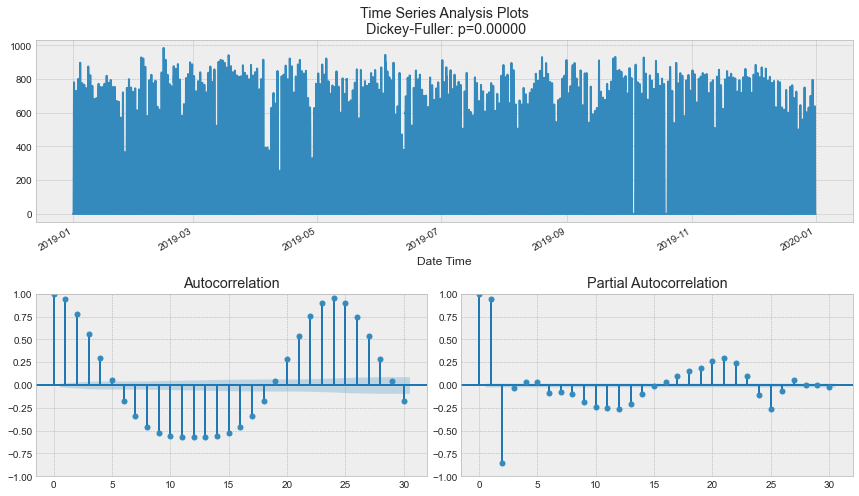

In [45]:
import statsmodels.formula.api as smf        
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(solar.price, lags=30)

##### Autocorrelation in time series data is when a time series is linearly related to a lagged version of itself. 
##### Partial autocorrelation gives the partial correlation of a stationary time series with its own lagged values.

### From the AC and PAC graphs above we can se that lags 1, 2, 10, 11, 12, 13, 23, 24 & 25 are the most correlated lags to our main time series, so let's include them as features in a DataFrame.

In [46]:
for i in [1, 2, 10, 11, 12, 13, 23, 24, 25]:
    solar["lag_{}".format(i)] = solar.price.shift(i)
solar.dropna(axis=0,inplace=True)
solar.head()

,price,lag_1,lag_2,lag_10,lag_11,lag_12,lag_13,lag_23,lag_24,lag_25
Date Time,,,,,,,,,,
2019-02-01 01:00:00,0.00,0.00,0.00,432.44,600.28,721.94,773.03,0.00,0.00,0.00
2019-02-01 02:00:00,0.00,0.00,0.00,240.30,432.44,600.28,721.94,0.00,0.00,0.00
2019-02-01 03:00:00,0.00,0.00,0.00,75.02,240.30,432.44,600.28,0.00,0.00,0.00
2019-02-01 04:00:00,0.00,0.00,0.00,5.32,75.02,240.30,432.44,0.00,0.00,0.00
2019-02-01 05:00:00,0.00,0.00,0.00,0.00,5.32,75.02,240.30,7.70,0.00,0.00


##### Now the 'price' column is our target column and all the lags are the features that our models will learn from. 

### Now let's see how correlated our DataFrame is.

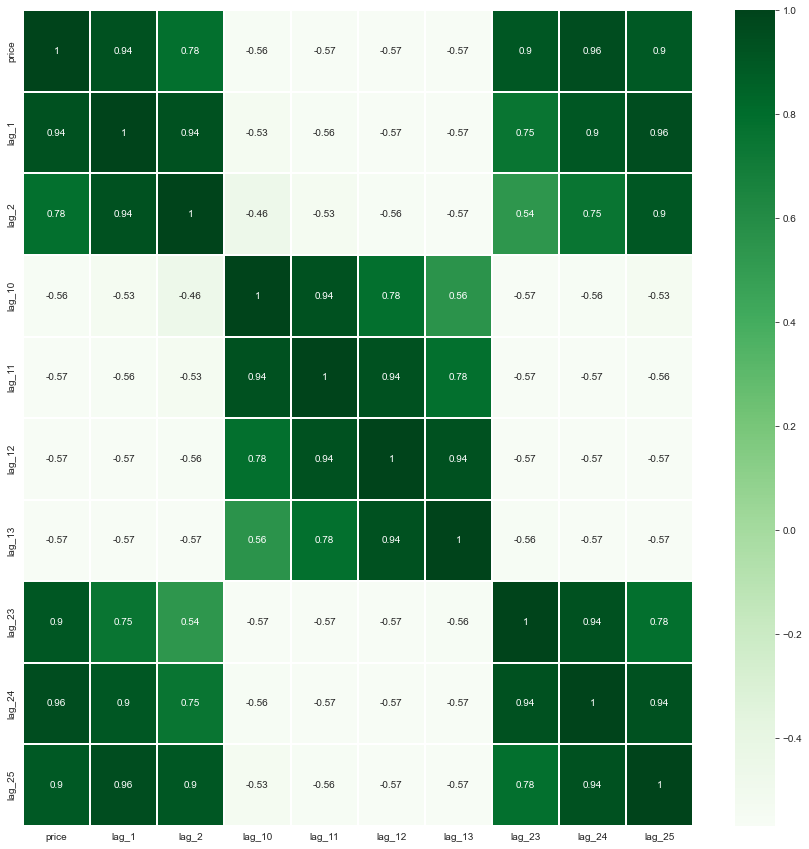

In [47]:
plt.figure(figsize=(15, 15))
sns.heatmap(solar.corr(), annot=True, cmap="Greens", linewidths=0.1, annot_kws={"fontsize":10});

## Preprocessing:

In [48]:
# Creating train and test sets:
solar.sort_index(inplace=True)
X = solar.drop(['price'], axis =1)
y = solar.price.to_frame()

# Scaling the data. 
data_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_data = data_scaler.fit_transform(X.values)
scaled_target = target_scaler.fit_transform(y.values)

scaled_data= pd.DataFrame(scaled_data, index=X.index, columns=X.columns)
scaled_target= pd.DataFrame(scaled_target, index=y.index, columns=y.columns)

x_train, x_test, y_train, y_test = train_test_split(scaled_data,scaled_target,test_size=0.1,shuffle=False, stratify = None)

In [49]:
x_train

,lag_1,lag_2,lag_10,lag_11,lag_12,lag_13,lag_23,lag_24,lag_25
Date Time,,,,,,,,,
2019-01-02 00:00:00,-0.75,-0.75,1.37,1.83,1.72,1.42,-0.75,-0.75,-0.75
2019-01-02 01:00:00,-0.75,-0.75,0.19,1.37,1.83,1.72,-0.75,-0.75,-0.75
2019-01-02 02:00:00,-0.75,-0.75,-0.34,0.19,1.37,1.83,-0.75,-0.75,-0.75
2019-01-02 03:00:00,-0.75,-0.75,-0.58,-0.34,0.19,1.37,-0.75,-0.75,-0.75
2019-01-02 04:00:00,-0.75,-0.75,-0.73,-0.58,-0.34,0.19,-0.75,-0.75,-0.75
...,...,...,...,...,...,...,...,...,...
2019-11-25 14:00:00,1.38,1.74,-0.75,-0.75,-0.75,-0.75,0.87,1.52,1.97
2019-11-25 15:00:00,0.98,1.38,-0.75,-0.75,-0.75,-0.75,0.15,0.87,1.52
2019-11-25 16:00:00,0.29,0.98,-0.66,-0.75,-0.75,-0.75,-0.54,0.15,0.87


In [50]:
y_test

,price
Date Time,
2019-11-25 19:00:00,-0.75
2019-11-25 20:00:00,-0.75
2019-11-25 21:00:00,-0.75
2019-11-25 22:00:00,-0.75
2019-11-25 23:00:00,-0.75
...,...
2019-12-31 19:00:00,-0.75
2019-12-31 20:00:00,-0.75
2019-12-31 21:00:00,-0.75


## LSTM:

In [51]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
245/245 [==============================] - 4s 8ms/step - loss: 0.1355
Epoch 2/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0558
Epoch 3/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0372
Epoch 4/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0265
Epoch 5/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0247
Epoch 6/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0226
Epoch 7/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0238
Epoch 8/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0223
Epoch 9/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0225
Epoch 10/10
245/245 [==============================] - 2s 7ms/step - loss: 0.0222


epochs=10 because the loss stops devolpping after the 10th epoch.

In [52]:
LSTMpredictions = model.predict(x_test)
LSTMpredictions = target_scaler.inverse_transform(LSTMpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
lstmmae = mean_absolute_error(y_test_descaled, LSTMpredictions)
lstmmse = mean_squared_error(y_test_descaled, LSTMpredictions)
lstmrmse = np.sqrt(lstmmse)
lstmr2 = r2_score(y_test_descaled, LSTMpredictions)
print(f'''
(a) LSTM Mean Absolute Error (lstmMAE): {lstmmae}
(b) LSTM Mean Squared Error (MlstmSE): {lstmmse}
(c) LSTM Root Mean Squared Errlstmor (RMSE): {lstmrmse}
(d) LSTM R² (R-Squared): lstm: {lstmr2}
''')

28/28 [==============================] - 1s 3ms/step

(a) LSTM Mean Absolute Error (lstmMAE): 22.058047358838127
(b) LSTM Mean Squared Error (MlstmSE): 1104.9723397150588
(c) LSTM Root Mean Squared Errlstmor (RMSE): 33.24112422459654
(d) LSTM R² (R-Squared): lstm: 0.9857305003550186



In [53]:
x_test.sort_index()

,lag_1,lag_2,lag_10,lag_11,lag_12,lag_13,lag_23,lag_24,lag_25
Date Time,,,,,,,,,
2019-11-25 19:00:00,-0.75,-0.62,1.05,0.51,-0.16,-0.66,-0.75,-0.75,-0.75
2019-11-25 20:00:00,-0.75,-0.75,1.40,1.05,0.51,-0.16,-0.75,-0.75,-0.75
2019-11-25 21:00:00,-0.75,-0.75,1.64,1.40,1.05,0.51,-0.75,-0.75,-0.75
2019-11-25 22:00:00,-0.75,-0.75,1.74,1.64,1.40,1.05,-0.75,-0.75,-0.75
2019-11-25 23:00:00,-0.75,-0.75,1.38,1.74,1.64,1.40,-0.75,-0.75,-0.75
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,-0.75,-0.43,0.30,-0.06,-0.47,-0.72,-0.75,-0.75,-0.75
2019-12-31 20:00:00,-0.75,-0.75,0.90,0.30,-0.06,-0.47,-0.75,-0.75,-0.75
2019-12-31 21:00:00,-0.75,-0.75,1.26,0.90,0.30,-0.06,-0.75,-0.75,-0.75


In [54]:
train = solar[:len(x_train)]
valid = solar[len(x_train):]
valid['Predictions'] = LSTMpredictions

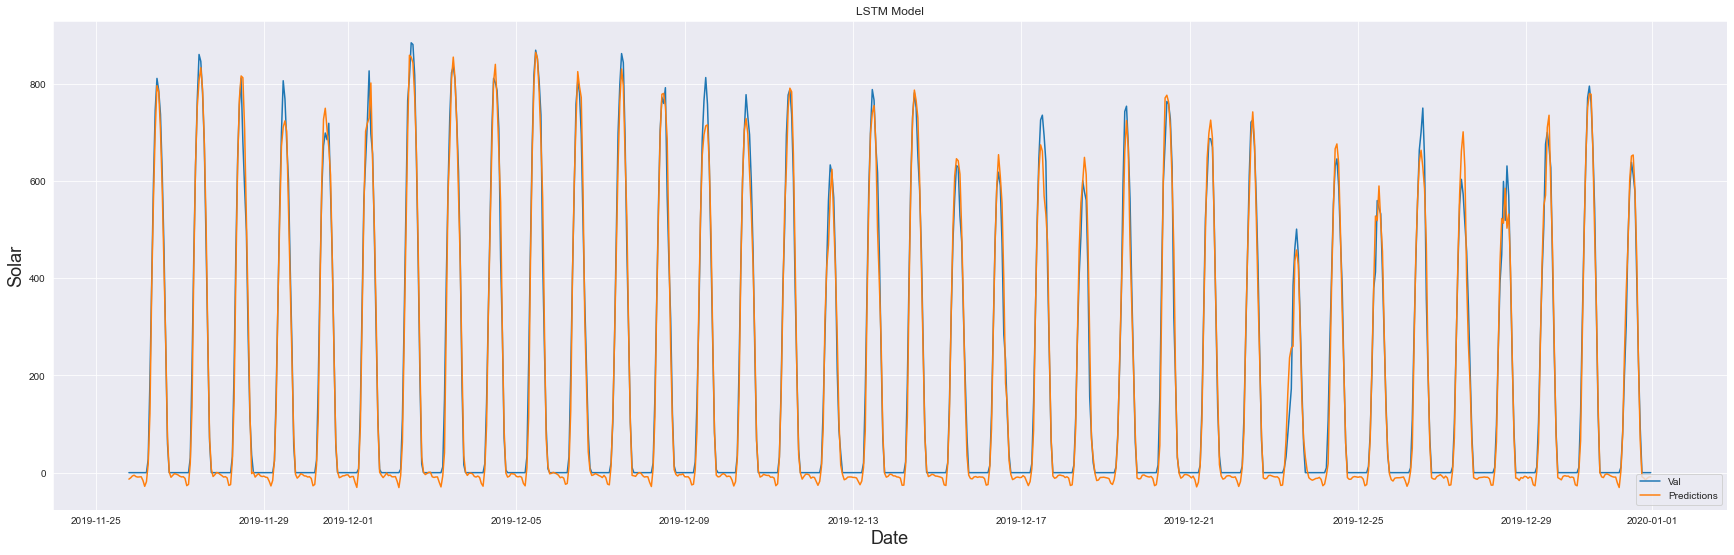

In [55]:
plt.figure(figsize=(30,9))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid[['price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

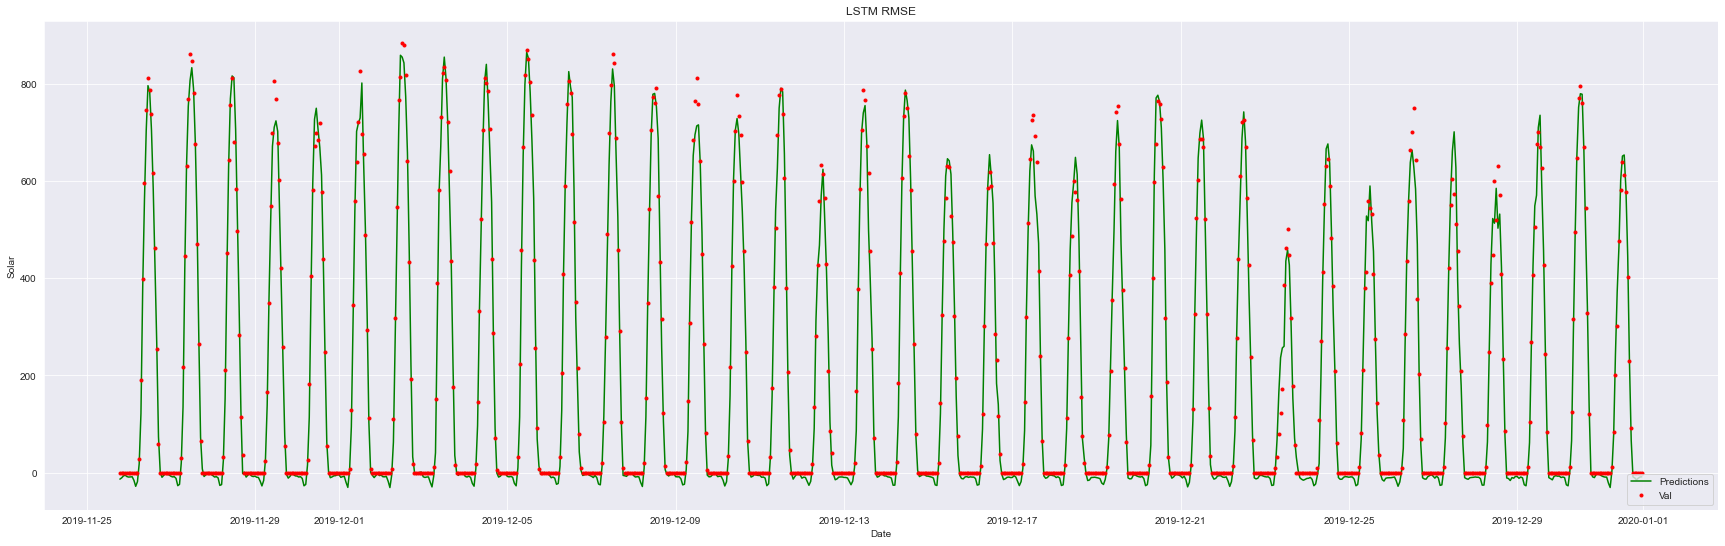

In [56]:
plt.figure(figsize=(30,9))
plt.plot(valid['Predictions'],'g-',label="Predictions")
plt.plot(valid['price'],'r.',label="Val")
plt.ylabel('Solar')
plt.xlabel('Date')
plt.legend( loc='lower right')
plt.title('LSTM RMSE')
plt.grid(True)

### LSTM Score:

In [57]:
def LSTMscore(y_true,y_pred):
    
    g = 0
    for i in range(len(y_true)):
        x = (y_true[i] - y_pred[i]) **2
        g = g + x
    m = np.mean(y_true)
    y = 0
    for i in range(len(y_true)):
        y = y + ((y_true[i] - m) ** 2)
    return str(round((1 - (g / y))*100,2)) + '%'
    
LSTMscore(valid['price'],valid['Predictions'])

'98.57%'

#### Pretty good results.

## LSTM BI:

In [58]:
from keras.layers import Bidirectional

# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model2.add(Bidirectional(LSTM(64, return_sequences=False)))
model2.add(Dense(25))
model2.add(Dense(1))

# Compile the model2
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model2
model2.fit(x_train, y_train, epochs=12)

Epoch 1/12
245/245 [==============================] - 5s 8ms/step - loss: 0.1108
Epoch 2/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0393
Epoch 3/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0238
Epoch 4/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0202
Epoch 5/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0194
Epoch 6/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0188
Epoch 7/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0182
Epoch 8/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0180
Epoch 9/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0176
Epoch 10/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0170
Epoch 11/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0170
Epoch 12/12
245/245 [==============================] - 2s 8ms/step - loss: 0.0178


epochs=12 because the loss stops devolpping after the 12th epoch.

In [59]:
LSTMpredictions2 = model2.predict(x_test)
LSTMpredictions2 = target_scaler.inverse_transform(LSTMpredictions2)
y_test_descaled = target_scaler.inverse_transform(y_test)
lstmmae2 = mean_absolute_error(y_test_descaled, LSTMpredictions2)
lstmmse2 = mean_squared_error(y_test_descaled, LSTMpredictions2)
lstmrmse2 = np.sqrt(lstmmse)
lstmr22 = r2_score(y_test_descaled, LSTMpredictions2)
print(f'''
(a) LSTM Mean Absolute Error (lstmMAE): {lstmmae2}
(b) LSTM Mean Squared Error (MlstmSE): {lstmmse2}
(c) LSTM Root Mean Squared Errlstmor (RMSE): {lstmrmse2}
(d) LSTM R² (R-Squared): lstm: {lstmr22}
''')

28/28 [==============================] - 1s 3ms/step

(a) LSTM Mean Absolute Error (lstmMAE): 18.295015356875997
(b) LSTM Mean Squared Error (MlstmSE): 875.963726060063
(c) LSTM Root Mean Squared Errlstmor (RMSE): 33.24112422459654
(d) LSTM R² (R-Squared): lstm: 0.9886878941410842



In [60]:
train = solar[:len(x_train)]
valid = solar[len(x_train):]
valid['Predictions'] = LSTMpredictions2

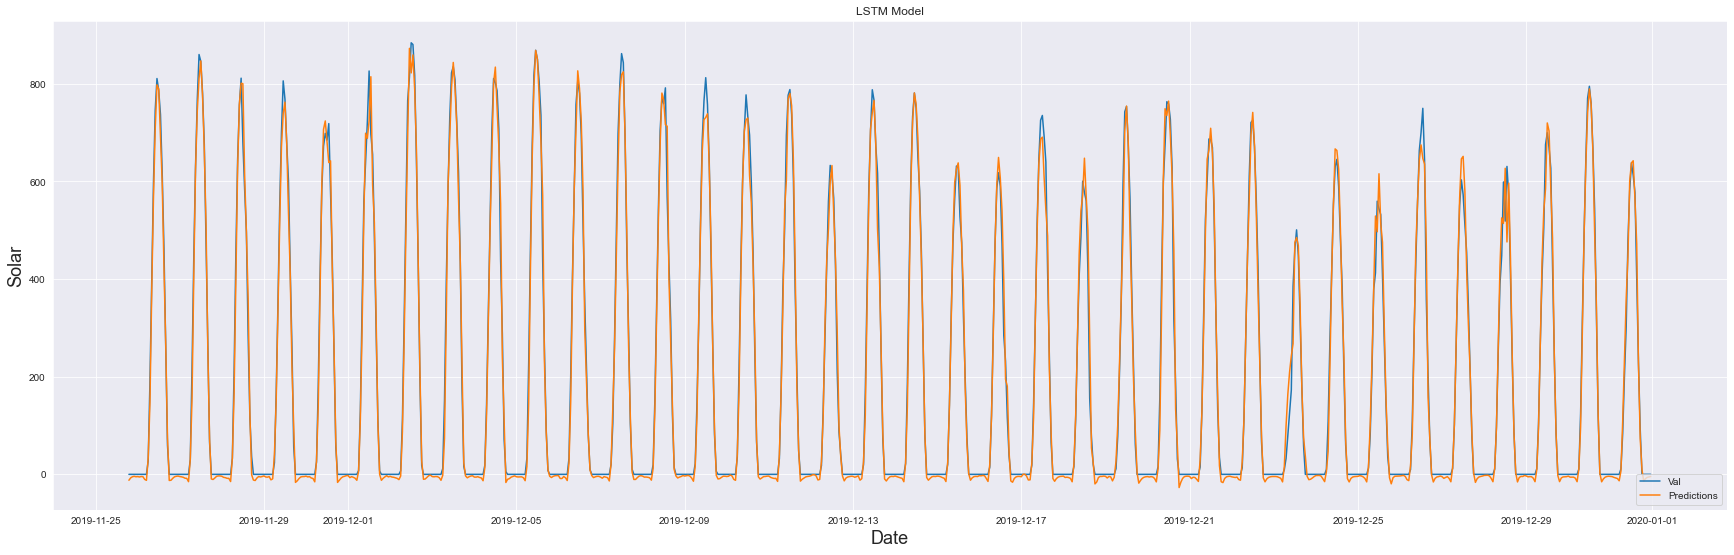

In [61]:
plt.figure(figsize=(30,9))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid[['price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

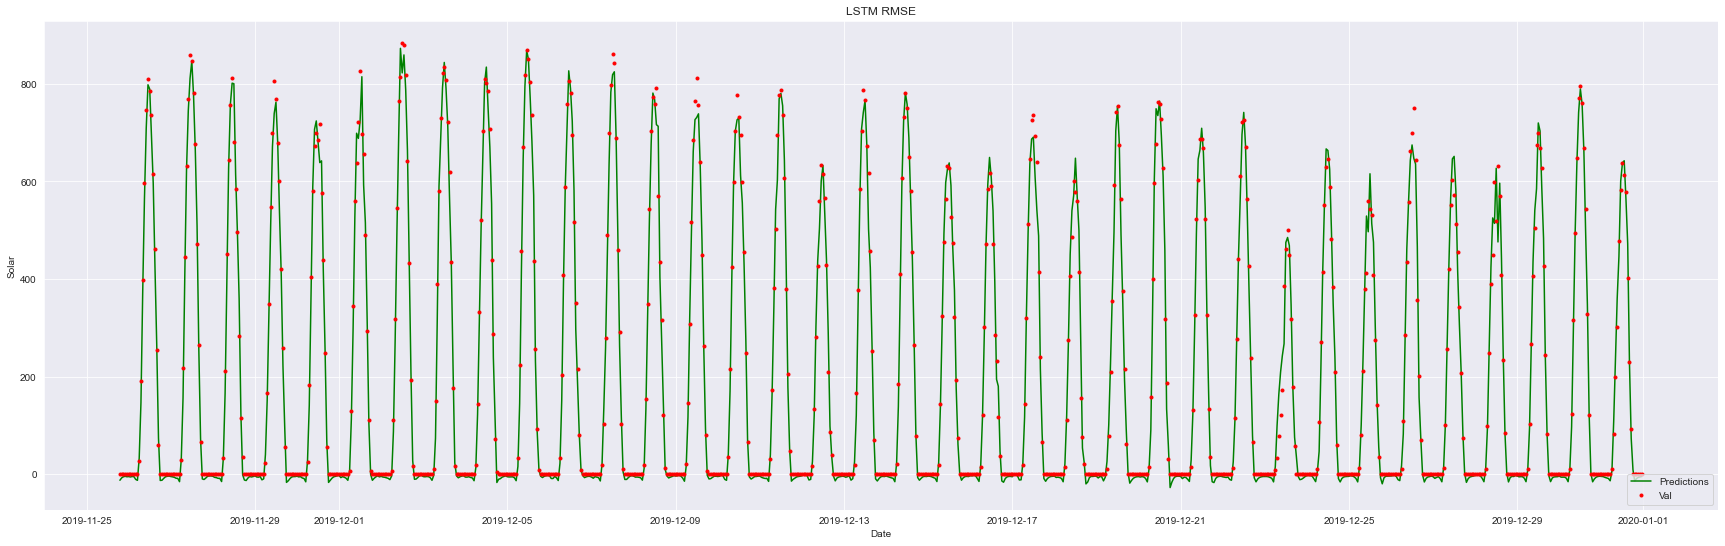

In [62]:
plt.figure(figsize=(30,9))
plt.plot(valid['Predictions'],'g-',label="Predictions")
plt.plot(valid['price'],'r.',label="Val")
plt.ylabel('Solar')
plt.xlabel('Date')
plt.legend( loc='lower right')
plt.title('LSTM RMSE')
plt.grid(True)

### LSTM-BI Score:

In [63]:
LSTMscore(valid['price'],valid['Predictions'])

'98.87%'

#### Even better results!

## KNN:

In [64]:
KNN_grid = {'n_neighbors' : list(range(3,100,2))}

knn = KNeighborsRegressor()

grid = GridSearchCV(knn, KNN_grid).fit(x_train,y_train)

In [65]:
knn = grid.best_estimator_
knn

KNeighborsRegressor(n_neighbors=7)

In [66]:
knn.fit(x_train,y_train)
KNN_pred = knn.predict(x_test)
KNN_pred = target_scaler.inverse_transform(KNN_pred)

knnmae = mean_absolute_error(y_test_descaled, KNN_pred)
knnmse = mean_squared_error(y_test_descaled, KNN_pred)
knnrmse = np.sqrt(knnmse)
knnr2 = r2_score(y_test_descaled, KNN_pred)
print(f'''
(a) KNN Mean Absolute Error (MAE): {knnmae}
(b) KNN Mean Squared Error (MSE): {knnmse}
(c) KNN Root Mean Squared Error (RMSE): {knnrmse}
(d) KNN R² (R-Squared): {knnr2}
''')


(a) KNN Mean Absolute Error (MAE): 16.283139898076616
(b) KNN Mean Squared Error (MSE): 1027.1330110236959
(c) KNN Root Mean Squared Error (RMSE): 32.04891591027216
(d) KNN R² (R-Squared): 0.9867357094749261



In [67]:
knn.score(x_test,y_test)

0.9867357094749261

In [68]:
train = solar[:len(x_train)]
valid = solar[len(x_train):]
valid['Predictions'] = KNN_pred

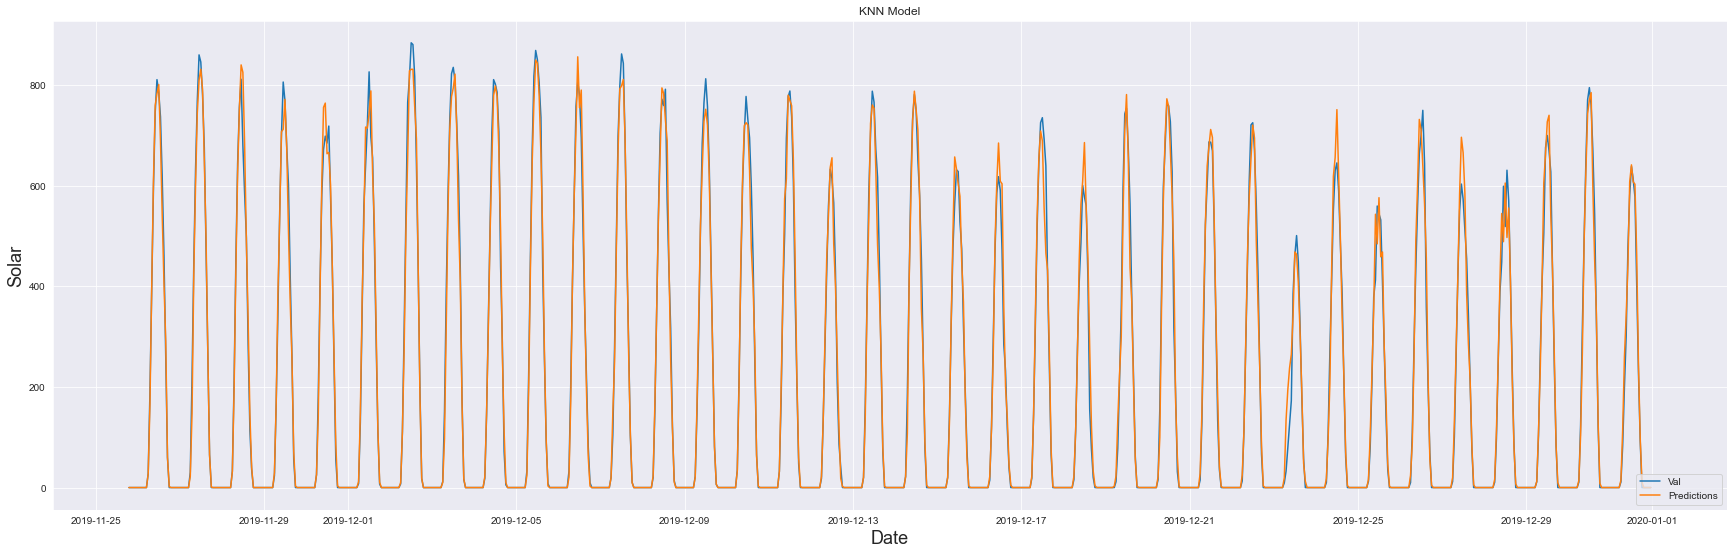

In [69]:
# Visualize the data
plt.figure(figsize=(30,9))
plt.title('KNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(valid[['price', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

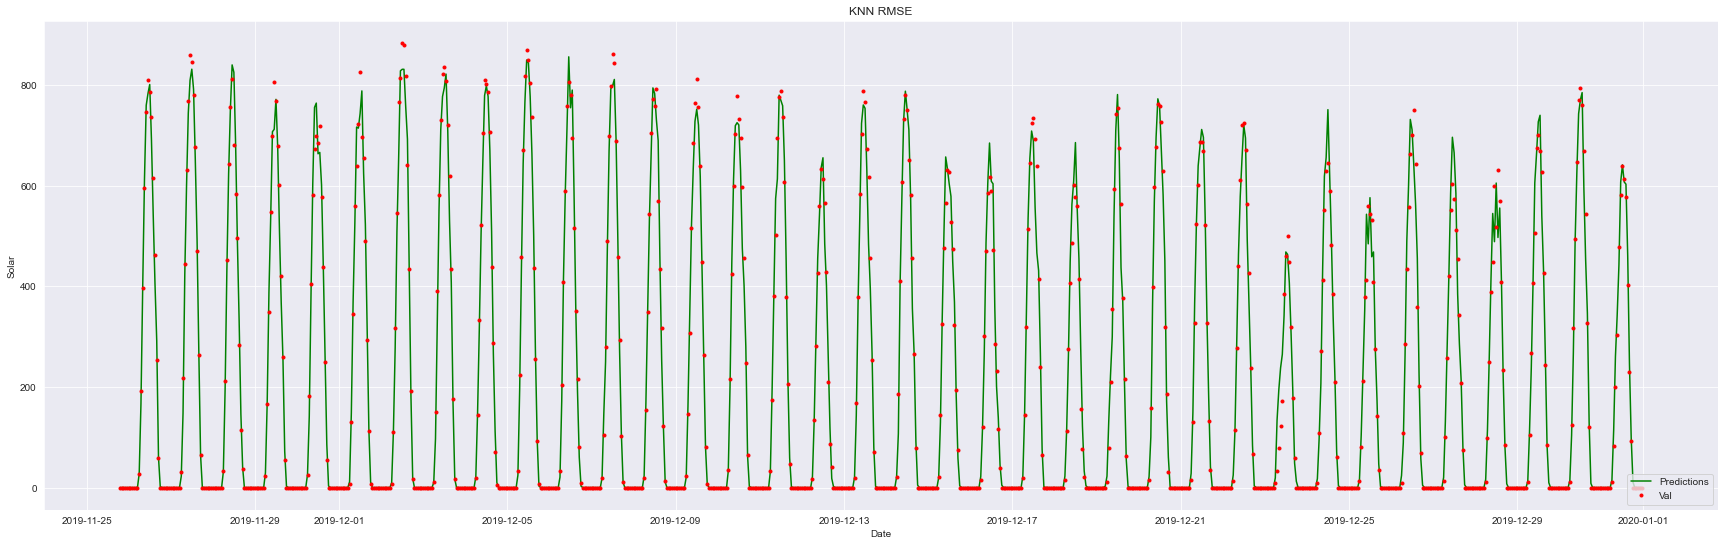

In [70]:
plt.figure(figsize=(30,9))
plt.plot(valid['Predictions'],'g-',label="Predictions")
plt.plot(valid['price'],'r.',label="Val")
plt.ylabel('Solar')
plt.xlabel('Date')
plt.legend( loc='lower right')
plt.title('KNN RMSE')
plt.grid(True)

## SVR:

In [71]:
param = {'kernel' : ('linear', 'poly', 'rbf'),'C' : [1,10],'coef0' : [0.01,0.1,1],'gamma' : ('auto','scale')}

svr = SVR()

grids = GridSearchCV(svr,param,cv=5)

grids.fit(x_train,y_train) 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 10], 'coef0': [0.01, 0.1, 1],
                         'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'poly', 'rbf')})

In [72]:
svr = grids.best_estimator_
svr

SVR(C=10, coef0=0.01, kernel='poly')

In [73]:
svr.fit(x_train,y_train)
svr_pred = svr.predict(x_test)
svr_pred = target_scaler.inverse_transform(svr_pred.reshape(-1, 1))

svrmae = mean_absolute_error(y_test_descaled, svr_pred)
svrmse = mean_squared_error(y_test_descaled, svr_pred)
svrrmse = np.sqrt(svrmse)
svrr2 = r2_score(y_test_descaled, svr_pred)
print(f'''
(a) svr Mean Absolute Error (MAE): {svrmae}
(b) svr Mean Squared Error (MSE): {svrmse}
(c) svr Root Mean Squared Error (RMSE): {svrrmse}
(d) svr R² (R-Squared): {svrr2}
''')


(a) svr Mean Absolute Error (MAE): 19.61074526788423
(b) svr Mean Squared Error (MSE): 883.3007625018142
(c) svr Root Mean Squared Error (RMSE): 29.720376217366667
(d) svr R² (R-Squared): 0.9885931444037941



### SVR Score:

In [74]:
svr.score(x_test,y_test)

0.9885931444037941

In [75]:
train = solar[:len(x_train)]
valid = solar[len(x_train):]
valid['Predictions'] = svr_pred

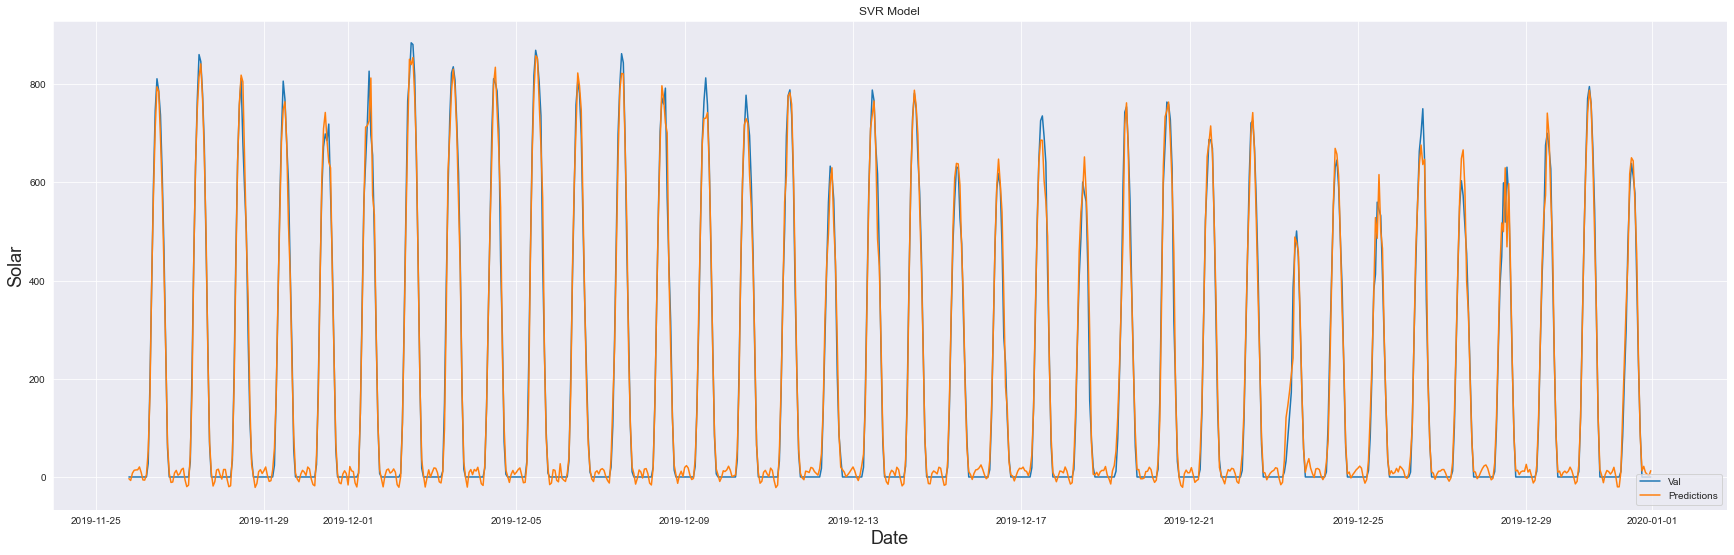

In [76]:
# Visualize the data
plt.figure(figsize=(30,9))
plt.title('SVR Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['price'])
plt.plot(valid[['price', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

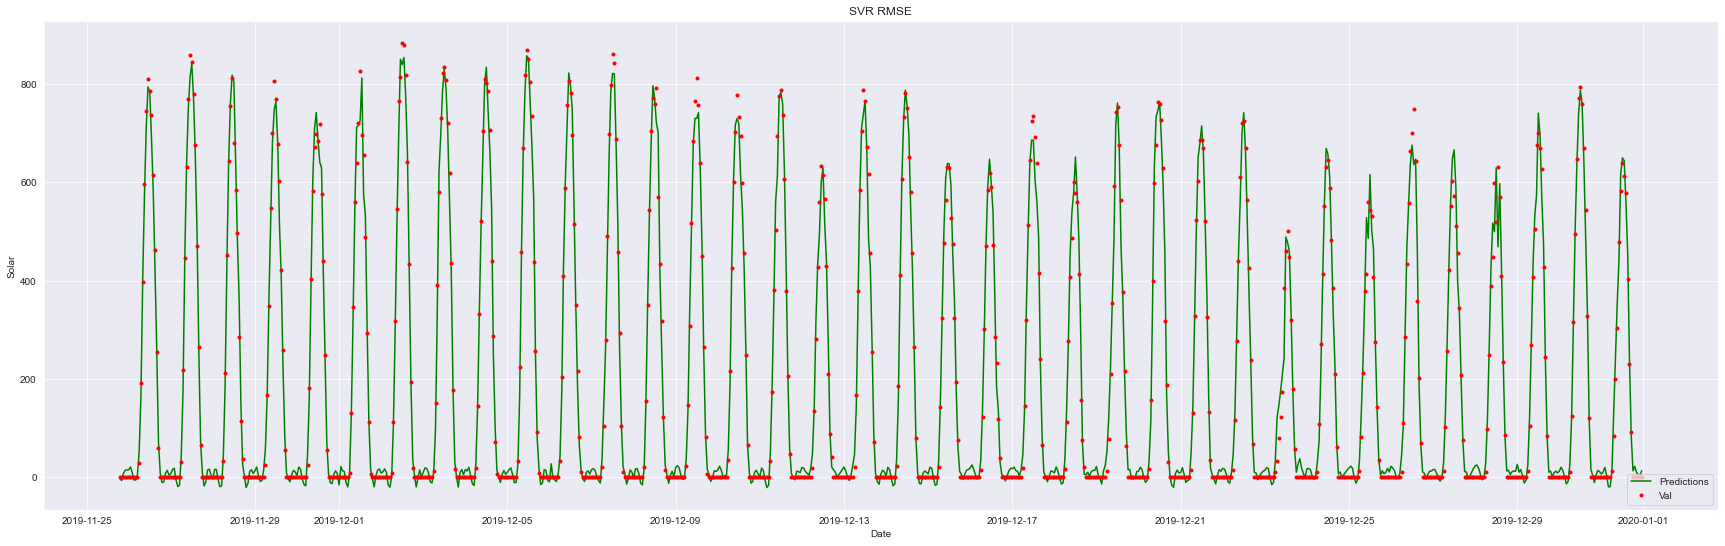

In [77]:
plt.figure(figsize=(30,9))
plt.plot(valid['Predictions'],'g-',label="Predictions")
plt.plot(valid['price'],'r.',label="Val")
plt.ylabel('Solar')
plt.xlabel('Date')
plt.legend( loc='lower right')
plt.title('SVR RMSE')
plt.grid(True)

## ARIMA:

In [78]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import warnings
warnings.filterwarnings("ignore")

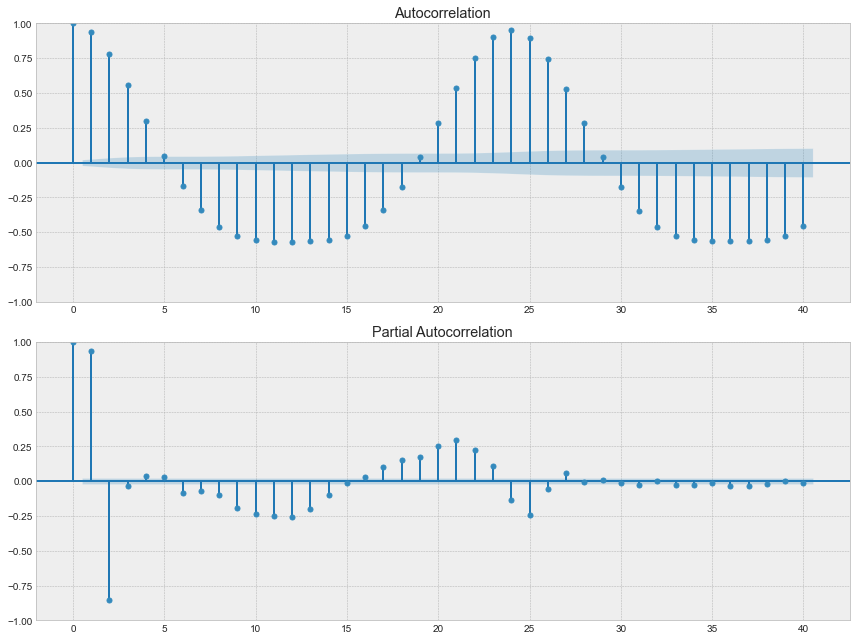

In [79]:
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(12, 9))
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    
    smt.graphics.plot_pacf(solar.price, ax=pacf_ax)
    smt.graphics.plot_acf(solar.price, ax=acf_ax)
    plt.tight_layout()

In [93]:
d = 0
p = 2
q = 25

d -> Differencing = the of differentiation we've implemented on our time series, and since we didn't differentiate our time series, then we will give it the value of 0.

p -> number of autoregressive terms = we can find this value by inspecting the PACF plot, from the PACF plot we can see that the first and second lags are significantly out of the limit and the third one is also out of the significant limit but it is not that far so we can select the order of the p as 2. 

q -> required moving average = to find out the value of q we can use the ACF plot, Here we can see that all of the lags are out of the significance limit so we can say that the optimal value of our q is 25. 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8687
Model:                ARIMA(2, 0, 25)   Log Likelihood              -45004.038
Date:                Sat, 11 Mar 2023   AIC                          90066.076
Time:                        16:06:36   BIC                          90271.094
Sample:                             0   HQIC                         90135.961
                               - 8687                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        217.3960      3.748     58.003      0.000     210.050     224.742
ar.L1          1.9304      0.001   3497.669      0.000       1.929       1.931
ar.L2         -0.9985      0.001  -1912.657      0.0

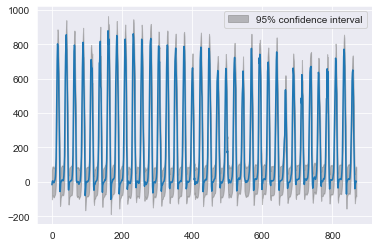

In [94]:
# building the ARIMA model.
model = sm.tsa.arima.ARIMA(solar.price.values, order=(p,d,q))
Aresult = model.fit()
print(Aresult.summary())
plot_predict(Aresult,start=len(y_train),end=len(solar)-1)
plt.show()

In [95]:
arima_pred = Aresult.predict(start=len(y_train),end=len(solar)-1)
# arima_pred = target_scaler.inverse_transform(arima_pred.reshape(-1, 1))

arimamae = mean_absolute_error(y_test_descaled, arima_pred)
arimamse = mean_squared_error(y_test_descaled, arima_pred)
arimarmse = np.sqrt(arimamse)
arimar2 = r2_score(y_test_descaled, arima_pred)
print(f'''
(a) arima Mean Absolute Error (MAE): {arimamae}
(b) arima Mean Squared Error (MSE): {arimamse}
(c) arima Root Mean Squared Error (RMSE): {arimarmse}
(d) arima R² (R-Squared): {arimar2}
''')


(a) arima Mean Absolute Error (MAE): 27.42689956252619
(b) arima Mean Squared Error (MSE): 1431.278259571524
(c) arima Root Mean Squared Error (RMSE): 37.832238363220384
(d) arima R² (R-Squared): 0.9815166191199934



In [96]:
0.9815166191199934

0.9815166191199934

In [97]:
train = solar[:len(x_train)]
valid = solar[len(x_train):]
valid['Predictions'] = arima_pred

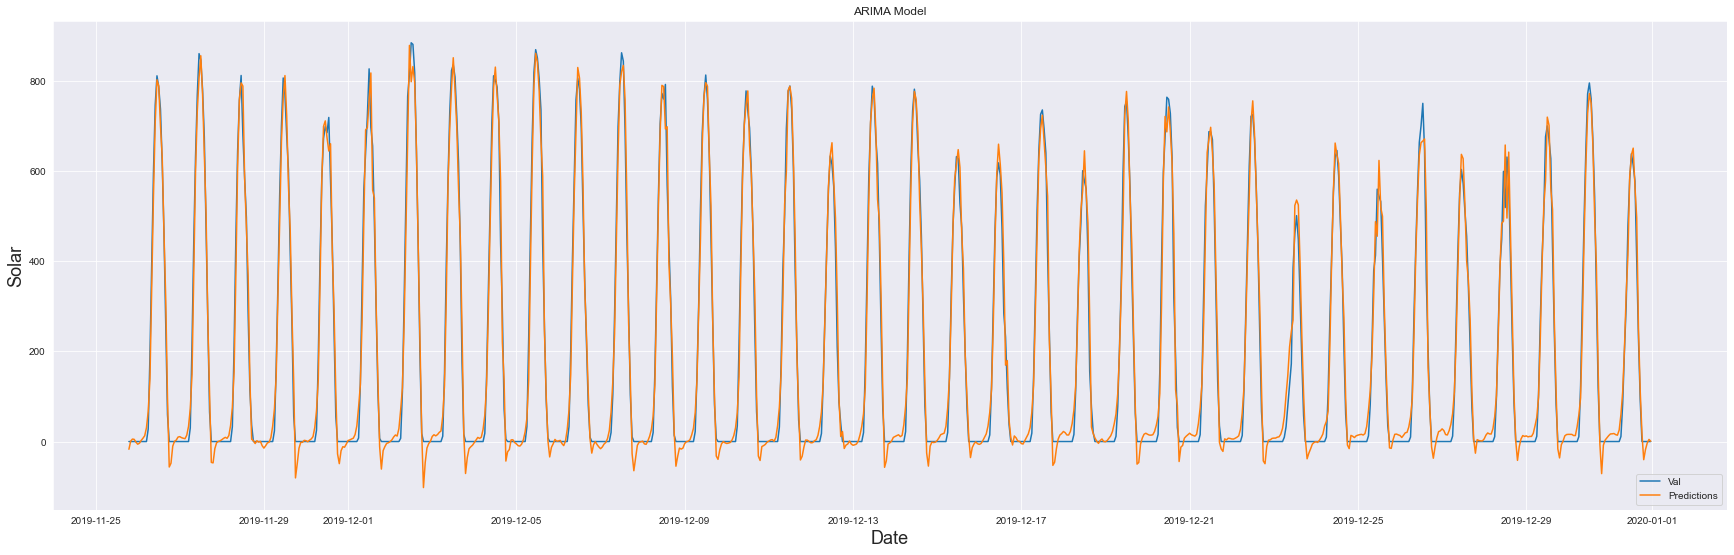

In [98]:
# Visualize the data
plt.figure(figsize=(30,9))
plt.title('ARIMA Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['price'])
plt.plot(valid[['price', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

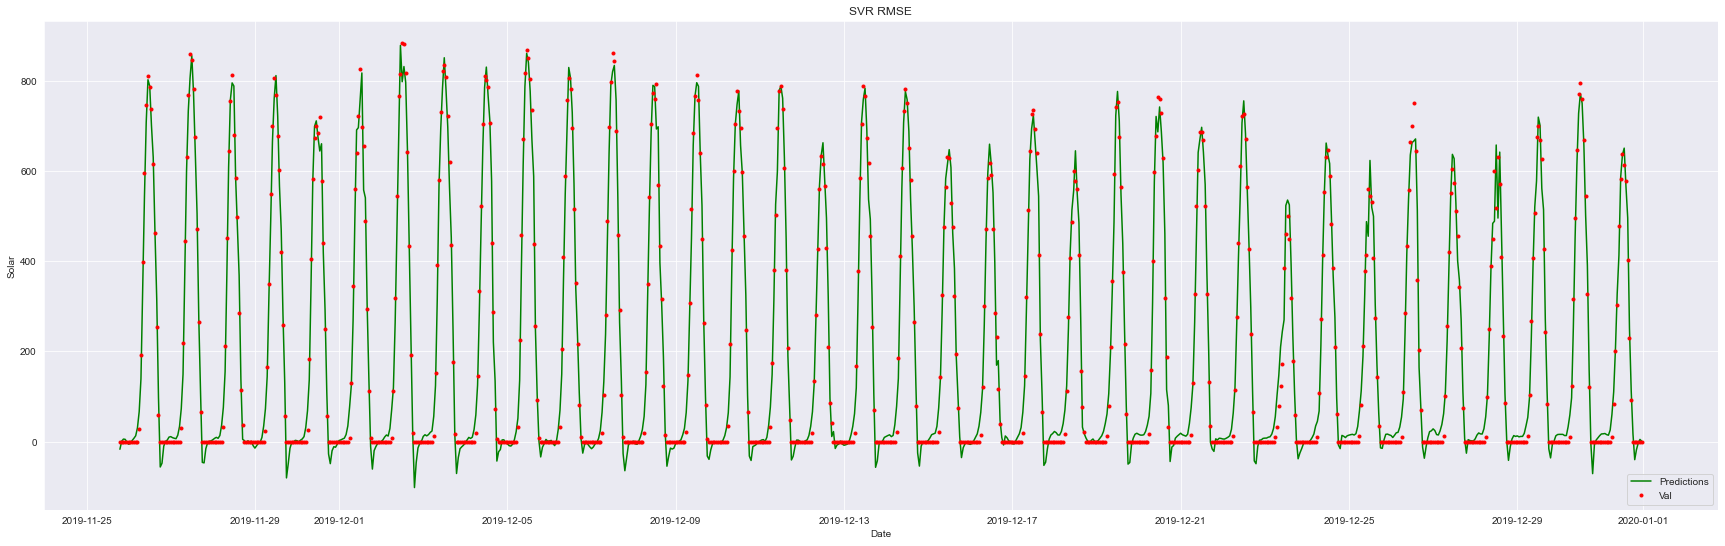

In [99]:
plt.figure(figsize=(30,9))
plt.plot(valid['Predictions'],'g-',label="Predictions")
plt.plot(valid['price'],'r.',label="Val")
plt.ylabel('Solar')
plt.xlabel('Date')
plt.legend( loc='lower right')
plt.title('SVR RMSE')
plt.grid(True)

In [100]:
LSTMscore(valid['price'],valid['Predictions'])

'98.15%'

## RMSE:

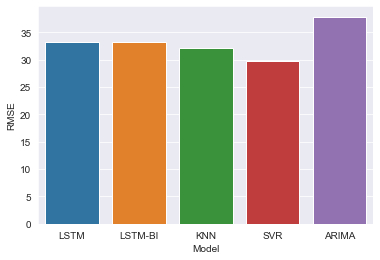

In [101]:
df = pd.DataFrame([[lstmrmse,lstmrmse2,knnrmse,svrrmse,arimarmse],['LSTM','LSTM-BI','KNN','SVR','ARIMA']]).T
df.columns=['RMSE','Model']
sns.barplot(data=df, x="Model", y="RMSE");

## MAE:

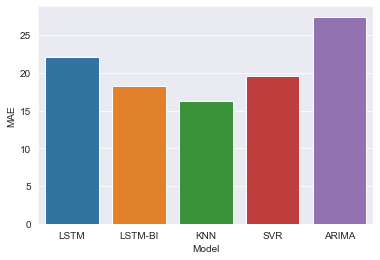

In [102]:
df = pd.DataFrame([[lstmmae,lstmmae2,knnmae,svrmae,arimamae],['LSTM','LSTM-BI','KNN','SVR','ARIMA']]).T
df.columns=['MAE','Model']
sns.barplot(data=df, x="Model", y="MAE");